In [1]:
#install.packages('mistr')
library(rugarch)
library(VineCopula)
library(fGarch) 
library(quantreg)
library(readxl)
library(xts)
library(mistr)

Loading required package: parallel


Attaching package: 'rugarch'


The following object is masked from 'package:stats':

    sigma


NOTE: Packages 'fBasics', 'timeDate', and 'timeSeries' are no longer
attached to the search() path when 'fGarch' is attached.

If needed attach them yourself in your R script by e.g.,
        require("timeSeries")

Loading required package: SparseM


Attaching package: 'SparseM'


The following object is masked from 'package:base':

    backsolve


Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



Attaching package: 'mistr'


The following object is masked from 'package:base':

    q




In [2]:
#用相对路径读取数据更整洁，代码鲁棒性更强
df <- read_excel("./test.xlsx")
df$日期 <- as.Date(df$日期, format = "%Y-%m-%d")
# 调整为日期格式
ts_df <- xts(df[-1], order.by = df$日期)
date_st <- index(ts_df)
dim(ts_df)
tail(ts_df)

[1] 1678   39

           香蜜湖指数   中国银行   工商银行   交通银行   建设银行   中信银行
2024-04-16 -4.0291639  1.0834342  0.9182801  0.2989539  0.4192878 -1.5015297
2024-04-17  4.2765524  0.4301082  0.5469476  0.8915364  1.5225208  9.5172638
2024-04-18 -0.3160644  0.6417134  0.3629768  1.3225762  0.2743486  8.6896744
2024-04-19 -1.6792034  0.6376217  0.5420067  0.7272759  0.6825965 -8.6896744
2024-04-22  0.3443545 -1.2793351 -1.2692827 -0.8733680 -0.6825965 -3.4993074
2024-04-23  0.5518959  0.0000000  0.3642991  1.1628038  0.1368926  0.2844952
              平安银行   浦发银行    招商银行   华夏银行    中信证券   海通证券
2024-04-16 -0.09722898 -0.5494519 -0.24397694 -0.3007521 -0.62199805 -1.6571444
2024-04-17  3.25387558  1.0959014  1.66544349  1.9389123  2.63099419  1.9096697
2024-04-18  1.68071183 -0.1363327  1.04556591  0.8823587  0.60589555  1.6260521
2024-04-19 -1.02374091  0.1363327 -0.08919281  0.2923979 -0.44028690 -0.2484473
2024-04-22 -1.79334679 -0.6835297 -0.83632507 -0.5856532  0.82395413  0.6199648
2024-04-23  0.38022859  0.6835

1.对两个市场收益率的均值和波动率建模ARMA（1，2）-EGARCH得到两个边缘分布；其中均值模型使用了ARMA（1，2）；方差模型使用了eGARCH模型，这种模型可以捕捉金融时间序列数据的波动聚集和杠杆效应（正负信息对波动影响不同）；分布使用了偏斜的学生t分布，这允许模型对尾部厚度和偏度进行建模。
2.使用 ugarchfit 函数应用上述定义的模型规范来拟合名为 ts_df 的数据框中的时间序列数据。通过 apply 函数对每列数据应用GARCH模型拟合。
3.fit 对象包含了拟合结果，对于每一列时间序列数据，这个对象都保存了模型的详终拟合信息。
4.？正常arma egarch模型建完是不是要对残差进行白噪声的检验?这里没做是有什么原因吗

In [9]:
#ARMA egarch model
uspec <- ugarchspec(mean.model = list(armaOrder = c(1,2), include.mean = TRUE),
variance.model = list(model = "eGARCH"), 
distribution.model = "sstd")
# #用刚刚定义的模型拟合各列数据
# f1 <- function(x) {ugarchfit(uspec, data = x)}
# fit <- apply(ts_df,2, f1)

In [3]:
# 保存ugarchfit对象，这样就不用重复跑了
# saveRDS(fit, file = "garch_model.rds")
#读取模型
fit <- readRDS(file = "garch_model.rds")

绘制了两个特定序列（"香蜜湖指数"和"中国银行"）的图像，其中 which=1 指的是绘制这些模型拟合后的条件标准差。图展示了时间序列的波动性随时间的变化。图中的波动性是模型预测的，反映了在不同时间点的不确定性或风险水平。某个时期图像显示波动性上升，这可能意味着那段时间市场更加动荡，风险更高。

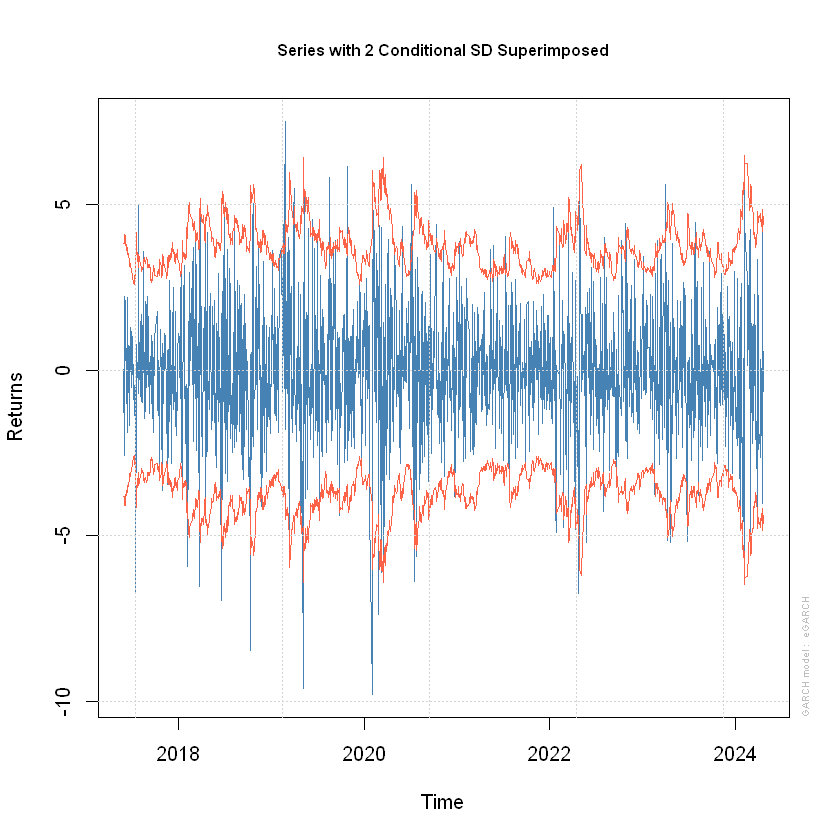

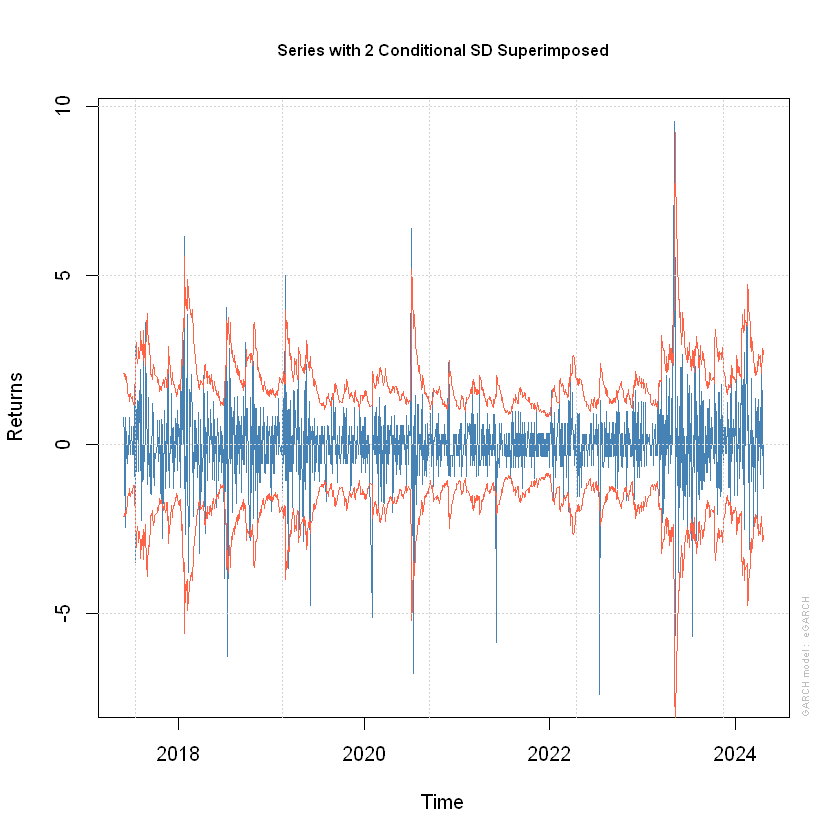

In [6]:
#绘图（先以香蜜湖指数和中国银行为例）
plot(fit$香蜜湖指数,which=1)
plot(fit$中国银行,which=1)

从拟合后的GARCH模型中提取残差（预测值和真实值的差异），并将残差和具体日期对应。

In [4]:
fintech_resi <- residuals(fit$香蜜湖指数)
index(fintech_resi) <- date_st
cbank_resi <- residuals(fit$中国银行)
index(cbank_resi) <- date_st

1.复制模型：将之前定义的 uspec GARCH模型规范复制到一个新变量 spec_cbank 中，目的是保留原始的模型规范，同时可以对新的规范进行修改而不影响原始规范。2.固定模型系数：coef(fit$中国银行) 提取了之前拟合的 fit$中国银行 GARCH模型的系数。setfixed 函数用于将这些系数固定在 spec_cbank 模型规范中。这意味着在使用 spec_cbank 进行进一步的模型操作时，这些系数将不会改变，模型会使用这些固定的系数值进行计算。3.过滤新数据（不太理解作用是啥）：
？？数据是相同的，固定参数后再代入一样的数据主要目的是评估条件方差和残差。

In [10]:
##process of Returns of the 中国银行
spec_cbank <- uspec
setfixed(spec_cbank) <- as.list(coef(fit$中国银行))

filt_cbank <- ugarchfilter(spec_cbank, ts_df$中国银行)



In [42]:
length(cbank_res) == length(sigma(filt_cbank))

[1] TRUE

1.创建了rrss数据框，有三列。cbank_res:  fit$中国银行模型中得到的残差序列；sigma(filt_cbank): 这表示从 filt_cbank 对象中提取的条件标准差序列。在GARCH模型中，sigma 通常用来衡量模型估计的时间序列数据的波动性；cbank_res/sigma(filt_cbank): 这是残差与其对应的条件标准差的比值，这个比值也被称为标准化残差。标准化残差是用来评估数据点与模型的偏离程度，通常用于检查模型是否合理地捕获了数据的波动性。（但是感觉残差好大啊？这是不是说明模型拟合的不太好？）
2.构建了ssss1，有五列。ts_df$中国银行: 原始的时间序列数据。fitted(filt_cbank): 从 filt_cbank 对象中提取的模型拟合值。在GARCH模型中，拟合值指模型预测的条件均值。cbank_res: 中国银行的残差序列。sigma(filt_cbank): 条件标准差序列。cbank_registro/sigma(filt_cbank): 标准化残差序列。

In [47]:
rrss <- cbind(cbank_resi,sigma(filt_cbank),cbank_resi/sigma(filt_cbank))
ssss <- cbind(ts_df$中国银行, fitted(filt_cbank), cbank_resi, sigma(filt_cbank), cbank_resi/sigma(filt_cbank))

cbank_res <- cbank_resi/sigma(filt_cbank)

针对香蜜湖指数做出了类似的操作。aaaa是合并了两个资产的标准化残差比较两个不同资产的标准化残差，可以分析它们的行为是否具有某些相似性或差异性，例如是否在同一时间点出现波动性集群。

In [52]:
##process of Returns of the 香蜜湖指数
spec_fintech <- uspec
setfixed(spec_fintech)<-as.list(coef(fit$香蜜湖指数))
filt_fintech <- ugarchfilter(spec_fintech, ts_df$香蜜湖指数)
rrss1 <- cbind(fintech_resi,sigma(filt_fintech),fintech_resi/sigma(filt_fintech))
ssss1 <- cbind(ts_df$香蜜湖指数,fitted(filt_fintech),fintech_resi,sigma(filt_fintech),fintech_resi/sigma(filt_fintech))
fintech_res <- fintech_resi/sigma(filt_fintech)
aaaa <- cbind(cbank_res, fintech_res)

In [38]:
write.csv(aaaa, "E:\\硕士毕业论文\\Rcode\\cbank_residuals.csv")
ts_df_1 <- read.csv('E:\\硕士毕业论文\\Rcode\\cbank_residuals.csv')

In [96]:
aaaa

              cbank_res  fintech_res
2017-05-31  0.735439511  0.023773345
2017-06-01  0.279166865 -1.337003089
2017-06-02 -0.503556494  1.082729269
2017-06-05 -2.538718822  0.522590093
2017-06-06  0.077554482  0.113520506
2017-06-07  0.748443286  1.143776843
2017-06-08 -0.029406606 -0.356542113
2017-06-09 -0.342300079 -0.103468856
2017-06-12 -0.689328875 -1.024243489
2017-06-13 -0.109512906  0.792310820
       ...                          
2024-04-10  0.159524822 -1.151414727
2024-04-11 -0.366602710  0.061843055
2024-04-12  0.171501728 -0.762440914
2024-04-15  2.074912518  0.002755536
2024-04-16  0.905572943 -1.880052763
2024-04-17  0.397092784  1.789244272
2024-04-18  0.541572495 -0.040126046
2024-04-19  0.547213474 -0.801419273
2024-04-22 -0.825137488  0.177661239
2024-04-23 -0.001350899  0.276981751

In [53]:
##input the redusuals of returns
dim(ts_df_1)
tail(ts_df_1)
tail(aaaa)

[1] 1678    3

,X,fintech_res.sigma.filt_fintech.,cbank_res.sigma.filt_cbank.
,<int>,<dbl>,<dbl>
1673,1673,-1.88005276,0.905572943
1674,1674,1.78924427,0.397092784
1675,1675,-0.04012605,0.541572495
1676,1676,-0.80141927,0.547213474
1677,1677,0.17766124,-0.825137488
1678,1678,0.27698175,-0.001350899


              cbank_res fintech_res
2024-04-16  0.905572943 -1.88005276
2024-04-17  0.397092784  1.78924427
2024-04-18  0.541572495 -0.04012605
2024-04-19  0.547213474 -0.80141927
2024-04-22 -0.825137488  0.17766124
2024-04-23 -0.001350899  0.27698175

EVT

Fitted composite GPD-Normal-GPD distribution: 

Breakpoints: -1.463908 1.045746 
Weights: 0.05006 0.847437 0.102503 

Parameters: 
     loc1    scale1    shape1      mean        sd      loc2    scale2    shape2 
 1.463908  0.638179  0.337510 -0.029169  0.743057  1.045746  0.576820  0.147214 

Log-likelihood: -2222.352,  Average log-likelihood: -1.3244


Composite distribution with: 
 
  Trafo       Distribution                                   Parameters Weight
1  -X   Generalized Pareto loc = 1.4639, scale = 0.6382, shape = 0.3375 0.0501
2 none        Normal               mean = -0.0292, sd = 0.7431          0.8474
3 none  Generalized Pareto loc = 1.0457, scale = 0.5768, shape = 0.1472 0.1025
        Truncation
1  (-Inf,-1.4639) 
2 [-1.4639,1.0457)
3   [1.0457,Inf)  

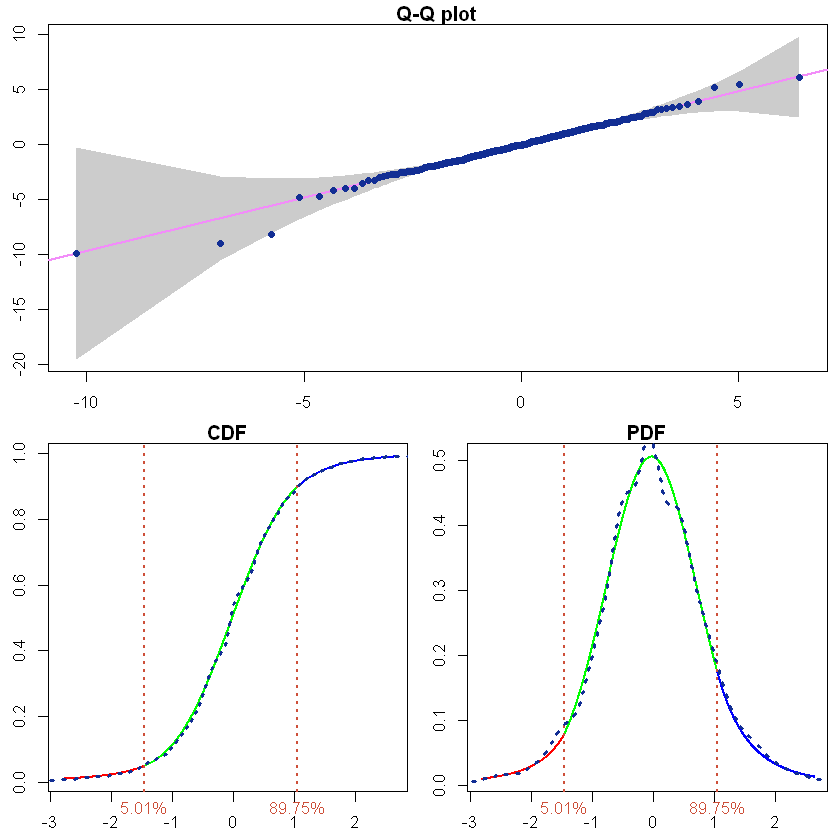

In [54]:
evt_cbank <- GNG_fit(cbank_res, start = c(break1 = -2, break2 =1.5, mean = 0, sd =1,shape1 = 0.1, shape2= 0.1))
evt_cbank
plot(evt_cbank)
distribution(evt_cbank)

Fitted composite GPD-Normal-GPD distribution: 

Breakpoints: -1.811639 1.779546 
Weights: 0.032777 0.929678 0.037545 

Parameters: 
    loc1   scale1   shape1     mean       sd     loc2   scale2   shape2 
1.811639 0.637257 0.081026 0.008827 0.878516 1.779546 0.650171 0.052678 

Log-likelihood: -2342.483,  Average log-likelihood: -1.396


Composite distribution with: 
 
  Trafo       Distribution                                   Parameters Weight
1  -X   Generalized Pareto loc = 1.8116, scale = 0.6373, shape = 0.081  0.0328
2 none        Normal                mean = 0.0088, sd = 0.8785          0.9297
3 none  Generalized Pareto loc = 1.7795, scale = 0.6502, shape = 0.0527 0.0375
        Truncation
1  (-Inf,-1.8116) 
2 [-1.8116,1.7795)
3   [1.7795,Inf)  

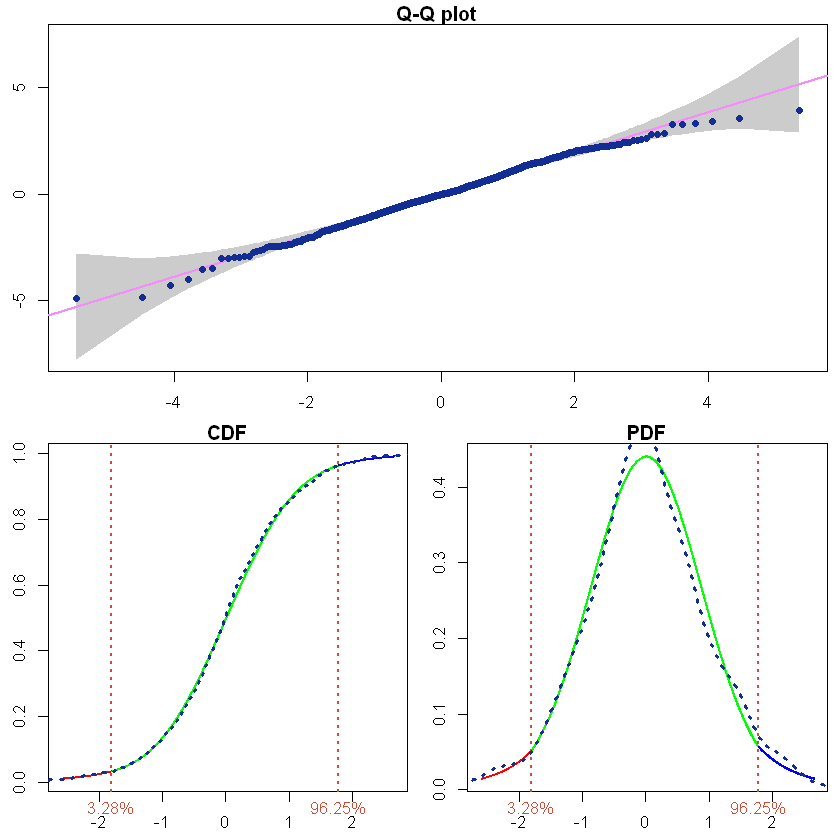

In [55]:
evt_fintech <- GNG_fit(fintech_res, start = c(break1 = -2, break2 =1.5, mean = 0, sd =1,shape1 = 0.1, shape2= 0.1))
evt_fintech
plot(evt_fintech)
distribution(evt_fintech)

使用order函数生成排序索引，基于香蜜湖指数标准化残差的索引从小到大排序时各个元素的索引位置。排序后cbind函数将两列数据合并为新数据框rd，由于两列数据都和标准化残差相关，这样操作方便同步比较香蜜湖指数和中国银行的表现。论文里面应该也没有体现这一点吧？没看出来是干什么用

Re: 我也觉得order没啥用

In [106]:
o <- order(ts_df_1$fintech_res.sigma.filt_fintech.)
rd <- cbind(ts_df_1$fintech_res.sigma.filt_fintech.[o], ts_df_1$cbank_res.sigma.filt_cbank.[o])
#x y 分别是香蜜湖和工商银行的标准化残差
x <- rd[, 1]
y <- rd[, 2]

In [107]:
rd

-4.895341,-8.981637182
-4.837504,2.474593907
-4.263329,-2.350231090
-4.006183,-2.728525684
-3.531735,0.375110200
-3.496894,-1.513498682
-3.016035,-1.375354867
-3.014693,-0.042449364
-2.972030,0.124062448
-2.944751,-1.965610346
-2.917280,-0.903836614


In [105]:
Dat <- NULL
Dat$x <- x
Dat$y <- y

使用有偏学生t分布来处理数据偏斜和厚尾特征，对xml和cbank进行拟合？（这个是不是只是把前面arma-egarch模型中ssst分布的参数给存到est.xml和est.cbank中了？

xml <- x
cbank <- y
est.xml <- as.numeric(sstdFit(xml)$estimate)
est.cbank <- as.numeric(sstdFit(cbank)$estimate)

1.分位数回归：计算了tau=0.05（5%分位数）和tau=0.95（95%分位数）的回归线。分位数回归可以支持刻画变量间关系在不同位置时的条件分布。（但是这里分位数曲线没看出作用，感觉它只是把中间90%的数据分出来了？也没有体现分位数回归的特点吧？

Re: 确实没啥作用，就是给你看看这个结果的确是对的，但是后面CoVar还是需要这个东西的

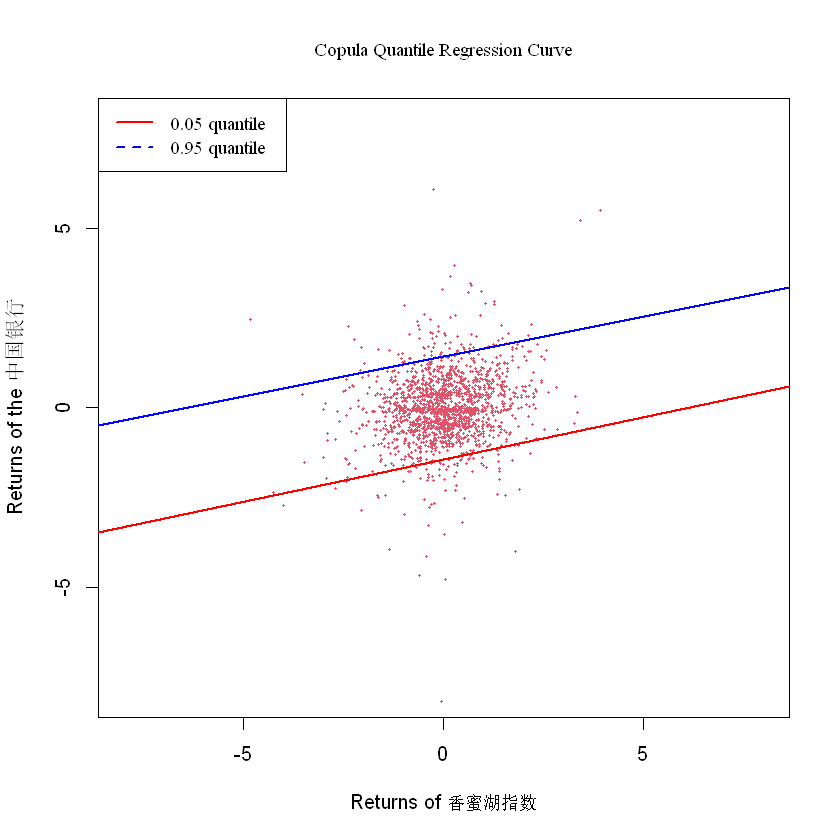

In [103]:

rq05 <- rq(y ~ x, tau = 0.05, data = Dat)  # 0.05分位数回归
rq95 <- rq(y ~ x, tau = 0.95, data = Dat)  # 0.95分位数回归
# 绘制基础图形
plot(x, y, col = 2, cex = 0.5, pch = 20, xlim = c(-8, 8), ylim = c(-8, 8),
     main = 'Copula Quantile Regression Curve', font.main = 6, cex.main = 0.95,
     xlab = 'Returns of 香蜜湖指数', ylab = 'Returns of the 中国银行')

# 添加分位数回归线
abline(rq05, col = "red", lwd = 2)  # 0.05分位数线
abline(rq95, col = "blue", lwd = 2)  # 0.95分位数线

# 添加图例
legend('topleft', c("0.05 quantile", "0.95 quantile"), col = c("red", "blue"),   
       lty = c(1, 2), lwd = c(2, 2), cex = 0.95, text.font = 6)


使用ssst分布的累计分布函数来转换数据x，建立copula模型的第一步。psstd是ssst分布的累积分布函数。这个函数的作用是计算数据在指定ssst分布参数下的累积概率。在copula模型中，通常需要将多变量数据转换为均匀分布（0到1之间）的边缘分布是通过各自的累积分布函数来实现的。

参数解释：x是需要被转换的数据，mean = est.xml[1]: 指定ssst分布的均值，sd = est.xml[2]: 指定分布的标准差，nu = est.xml[3]: 自由度参数，影响分布的尾部厚度，xi = est.xml[4]: 偏斜参数，决定数据偏斜的方向和程度

In [ ]:
#Rotated Gumbel copula quantile regression model
u <- psstd(x, mean = est.xml[1], sd = est.xml[2], nu = est.xml[3], xi = est.xml[4])


In [80]:

u <- p(distribution(evt_fintech),x)


gumbelmodel（这里用的条件copula吧？ ）是自己定义的（x为输入的数据，alpha为控制依赖结构的强度，mu和sigma为ssst分布的位置和尺度参数，tau为分位数，用于分位数回归）；初始化一个长度和u相同的矩阵的v，之后存放计算结果；然后转化数据为均匀分布（同上）；再计算copula函数：使用for循环遍历每一个u的值，rootf1为gumbel copula的逆函数，用于找到给定u值和tau分位数下的v值，再使用uniroot函数在给定范围内求解rootf1函数的根，即v；再使用qsstd将v转换回原始数据的尺度（mu + sigma * z）。
如果要把其他常用的四种也参与对比是不是要自己再对着这个条件copula的公式写四个函数？（如果上行风险也研究就更多，在想能不能只考虑下行风险？上行风险后续是不是只是站在对手方分析一下 会不会有点重复
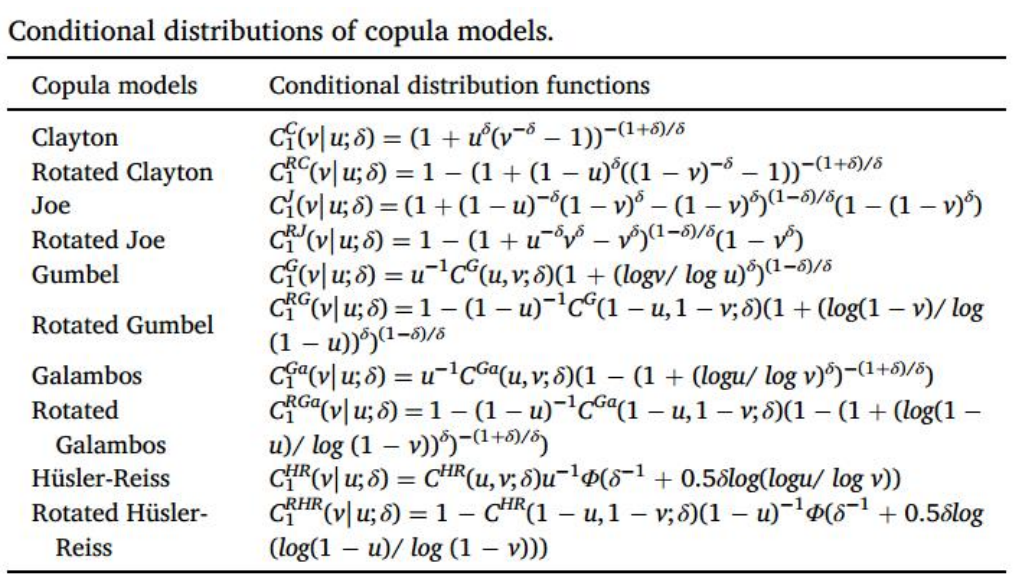

Re1: 对\
Re2：其实不是，我上次发给你那个东西里面是有集成了这些copula的函数的\
Re3: 增加工作量的话，没问题

下面代码块中copula里反映依赖关系的参数delta为定值，目的是得到v和z

In [82]:
# 初始化deltas矩阵
if(!exists("deltas") || !is.matrix(deltas)) {
    deltas <- matrix(NA, nrow = 10, ncol = 3)  # 适当调整行数和列数
}

GumbelModel <- function(x, alpha, mu, sigma, tau)
{
v <- matrix(0, length(u), 1)
u <- p(distribution(evt_fintech),x)
for(i in 1 :length(u))
{
rootf1 <- function(v){1 - exp(-((-log(1 - u[i]))^alpha + (-log(1 - v))^alpha)^(1/alpha)) * 
    (((-log(1 - u[i]))^alpha + (-log(1 - v))^alpha)^((1/alpha) - 
        1) * ((1/alpha) * ((-log(1 - u[i]))^(alpha - 1) * (alpha * 
        (1/(1 - u[i]))))))-tau}
vx <- uniroot(rootf1, c(0.00000000001, 0.999999999999))
v[i,1] <- vx$root
}
z <- mistr_q(distribution(evt_cbank),v)
mu + sigma * z
}
##mu is the panning parameter and sigma is the zooming parameter 


#初始化deltas矩阵(原)
if(!exists("deltas") || !is.matrix(deltas)) {
    deltas <- matrix(NA, nrow = 10, ncol = 3)  # 适当调整行数和列数
}

GumbelModel <- function(x, alpha, mu, sigma, tau)
{
v <- matrix(0, length(u), 1)
u <- psstd(x,mean=est.xml[1], sd=est.xml[2],nu=est.xml[3], xi=est.xml[4])
for(i in 1 :length(u))
{
rootf1 <- function(v){1 - exp(-((-log(1 - u[i]))^alpha + (-log(1 - v))^alpha)^(1/alpha)) * 
    (((-log(1 - u[i]))^alpha + (-log(1 - v))^alpha)^((1/alpha) - 
        1) * ((1/alpha) * ((-log(1 - u[i]))^(alpha - 1) * (alpha * 
        (1/(1 - u[i]))))))-tau}
vx <- uniroot(rootf1, c(0.00000000001, 0.999999999999))
v[i,1] <- vx$root
}
z <- qsstd(v, mean=est.cbank[1], sd=est.cbank[2], nu=est.cbank[3], xi=est.cbank[4])
mu + sigma * z
}

使用非线性回归nlrq来拟合旋转gumbel copula模型，并将结果可视化+储存。设置分位数进行非线性量化回归，设置tau=0.05表示关注5%的条件分位数，来估计极端低值的风险。用nlrq来拟合模型 y ~ GumbelModel(x, delta, mu, sigma, tau)，其中 GumbelModel 是之前定义的函数，利用Gumbel Copula模拟x和y的关系。start提供了模型参数的初值，和回归的收敛有关（？对初值的选择是怎么定的呀）而且看到下面输出结果里mu和sigma并不显著，是不是说明模型不好、还需要后续调分布或者copula？

Re:作者没说，所以我觉得应该没所谓\
Re:你看得很仔细，但是mu跟sigma是内点法的参数，这个可能跟Copula有关吗？我觉得如果你能通过换Copula或者分布来得到一组显著的mu跟sigma的话，是一个很好的贡献

下面代码块是内点法得到delta

188.5131 :   1.1257506 -0.1261274  1.0103893 
final  value 187.198775 
converged
lambda = 0.120895 
187.1988 :   1.12489863 -0.02051508  0.97888355 
final  value 186.552267 
converged
lambda = 0.2089306 
186.5523 :  1.0768648 0.2550766 1.1340460 
final  value 186.512965 
converged
lambda = 0.03409058 
186.513 :  1.0675485 0.3711296 1.2048942 
final  value 186.505002 
converged
lambda = 0.01358569 
186.505 :  1.0641160 0.4274175 1.2391994 
final  value 186.463644 
converged
lambda = 0.03338387 
186.4636 :  1.0554411 0.5733408 1.3346483 
final  value 186.462512 
stopped after 2 iterations
lambda = 0.001096709 
186.4625 :  1.0552794 0.5770777 1.3370754 
final  value 186.462512 
converged
lambda = 0 
186.4625 :  1.0552794 0.5770777 1.3370754 



Call: nlrq(formula = y ~ GumbelModel(x, delta, mu, sigma, tau), data = Dat, 
    start = list(delta = 1.1257506, mu = -0.1261274, sigma = 1.0103893), 
    tau = tau, trace = TRUE, control = list(maxiter = 100, k = 2, 
        InitialStepSize = 1, big = 1e+20, eps = 1e-07, beta = 0.97))

tau: [1] 0.05

Coefficients:
      Value   Std. Error t value Pr(>|t|)
delta 1.05528 0.15731    6.70833 0.00000 
mu    0.57708 4.36817    0.13211 0.89491 
sigma 1.33708 2.97074    0.45008 0.65271 

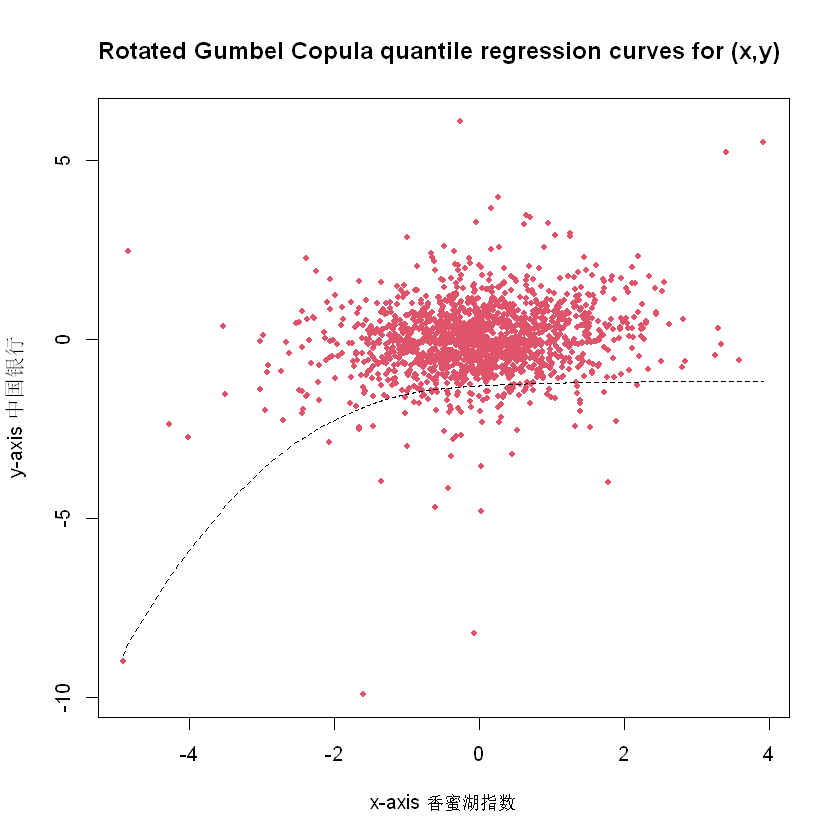

In [83]:
tau = 0.05
fit3 <- nlrq(y ~ GumbelModel(x, delta,mu, sigma, tau),
data=Dat, tau=tau, start = list(delta=1.1257506, mu=-0.1261274, sigma=1.0103893), trace=TRUE)
plot(x, y, main="Rotated Gumbel Copula quantile regression curves for (x,y) ", xlab="x-axis 香蜜湖指数", ylab="y-axis 中国银行", type='p',col = 2, pch=20)
lines(x, predict(fit3, newdata = x), lty = 2, lwd = 1, col = 1)
deltas[3,] <- coef(fit3)
summary(fit3)

和上面思路一样，但是换成了gumbel copula（因为论文模拟时发现gumbel适合拟合上行风险，这里用的是95%的分位数）

rootf1：条件gumbel copula

uniroot就是求copula的逆。已知u，得到tau在c(0.00000000001, 0.999999999999这个范围内的v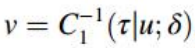
（这里u和v都是标准化残差 对应论文里是以下函数）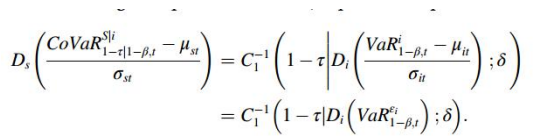

z为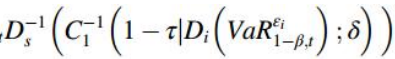

调整后的z为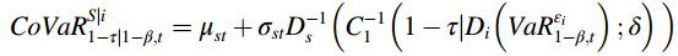

In [84]:
#Gumbel copula quantile regression model
u <- p(distribution(evt_fintech),x)
uGumbelModel <- function(x, delta, mu, sigma, tau)
{
v <- matrix(0, length(u), 1)
u <- p(distribution(evt_fintech),x)
for(i in 1 :length(u))
{
rootf1 <- function(v){exp(-((-log(u[i]))^delta + (-log(v))^delta)^(1/delta)) * (((-log(u[i]))^delta + 
   (-log(v))^delta)^((1/delta) - 1) * ((1/delta) * ((-log(u[i]))^(delta - 1) * (delta * (1/u[i])))))-tau}
vx <- uniroot(rootf1, c(0.000000001, 0.9999999999))
v[i,1] <- vx$root
}
z <- mistr_q(distribution(evt_cbank),v)
mu + sigma * z
}


下面为内点法求delta 但是其他参数为什么没显示估计结果？
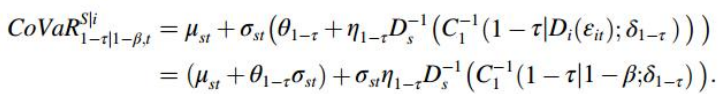
下面图像就是该回归式在tau=0.95时的

181.7765 :  1.2157506 0.1861274 1.0158930 
final  value 180.902102 
converged
lambda = 0.07733905 
180.9021 :  1.20321211 0.09228017 0.99855536 
final  value 180.064948 
converged
lambda = 0.2430127 
180.0649 :   1.1064157 -0.3001025  1.1569771 
final  value 179.731959 
converged
lambda = 0.4657588 
179.732 :   1.0527323 -0.8464435  1.4943307 
final  value 179.549134 
converged
lambda = 0.1824564 
179.5491 :   1.039350 -1.352598  1.832033 
final  value 179.535802 
converged
lambda = 0.00425415 
179.5358 :   1.036783 -1.493218  1.925947 
final  value 179.513994 
converged
lambda = 0.00750041 
179.514 :   1.033727 -1.689543  2.058003 
final  value 179.504124 
converged
lambda = 0.003400325 
179.5041 :   1.032252 -1.805164  2.135558 
final  value 179.491884 
converged
lambda = 0.004483141 
179.4919 :   1.030424 -1.962344  2.241606 
final  value 179.288641 
stopped after 7 iterations
lambda = 0.1718462 
179.2886 :   1.024282 -2.699321  2.748141 
final  value 179.288400 
converged
lambda = 


Call: nlrq(formula = y ~ uGumbelModel(x, delta, mu, sigma, tau), data = Dat, 
    start = list(delta = 1.2157506, mu = 0.1861274, sigma = 1.015893), 
    tau = tau, trace = TRUE, control = list(maxiter = 100, k = 2, 
        InitialStepSize = 1, big = 1e+20, eps = 1e-07, beta = 0.97))

tau: [1] 0.95

Coefficients:
      Value    Std. Error t value  Pr(>|t|)
delta  1.02435  0.39183    2.61424  0.00902
mu    -2.68836 60.73638   -0.04426  0.96470
sigma  2.74078 40.90128    0.06701  0.94658

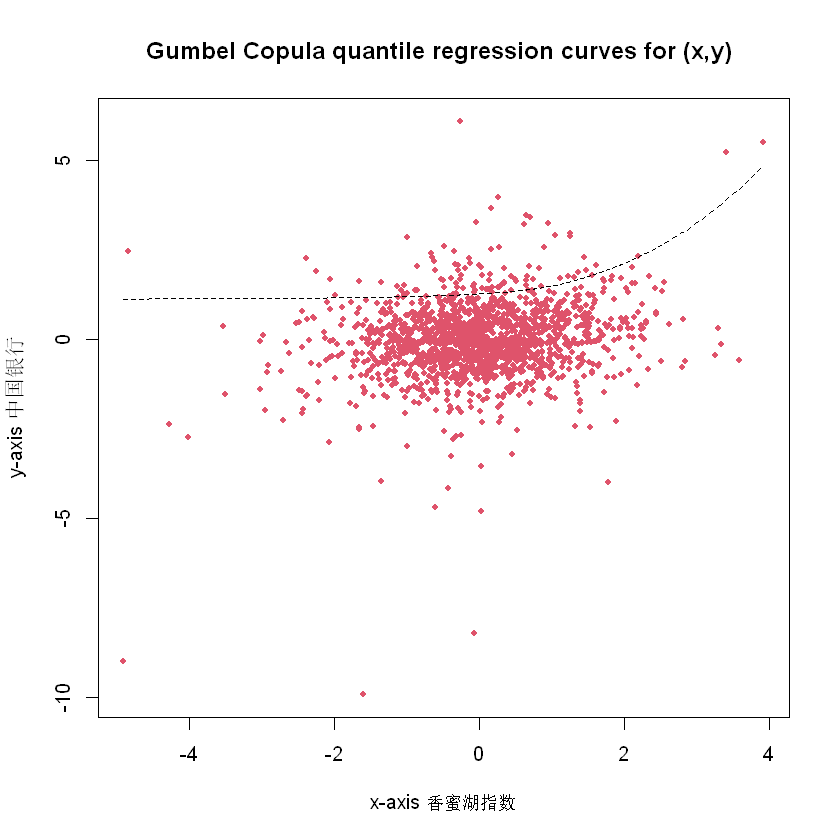

In [85]:
tau=0.95
fit1 <- nlrq(y ~ uGumbelModel(x, delta, mu, sigma, tau),
data=Dat, tau=tau, start=list(delta=1.2157506, mu=0.1861274, sigma=1.015893), trace=TRUE)
plot(x, y, main="Gumbel Copula quantile regression curves for (x,y) ", xlab="x-axis 香蜜湖指数", ylab="y-axis 中国银行", type='p',col = 2, pch=20)
lines(x, predict(fit1, newdata=x), lty=2, lwd=1, col=1)
deltas[3,] <- coef(fit1)
summary(fit1)

估计CoVaR，即在给定金融市场中某个资产或指数处于其特定分位数水平时，另一个资产或指数可能达到的最不利的值。首先，定义了四个不同的概率水平，用于评估这些水平下的covar；之后提取了拟合模型的系数（fit3中提取delta copula参数，mu分布的位置和sigma尺度参数；引入一个循环对每个概率水平都使用rootf1函数求解基于选择gumbel copula与阈值对应的v值，再使用qsst将v转换为给定阈值下的分位数值，最后结合位置参数和尺度参数计算得到最终的条件风险值f_hat_u。

In [86]:
#########################estimate the CoVaR######tau=0.05
tau <- 0.05
u_u <- c(0.5, 0.1, 0.05, 0.01)

delta <- coef(fit3)[1]
mu <- coef(fit3)[2]
sigma <- coef(fit3)[3]

v_f <- c(0, 0, 0, 0)
v_x <- c(0, 0, 0, 0)
for(i in 1:4)
{
rootf1<-function(v){1 - exp(-((-log(1 - u_u[i]))^delta + (-log(1 - v))^delta)^(1/delta)) * 
    (((-log(1 - u_u[i]))^delta + (-log(1 - v))^delta)^((1/delta) -
        1) * ((1/delta) * ((-log(1 - u_u[i]))^(delta - 1) * (delta *
        (1/(1 - u_u[i]))))))-tau}
vx<-uniroot(rootf1, c(0.00000001, 0.99999999))
v_x[i] <- vx$root
v_f[i] <- qsstd(v_x[i], mean=est.cbank[1], sd=est.cbank[2], nu=est.cbank[3], xi=est.cbank[4])
}

z_u <- v_f

f_hat_u <- mu+sigma*z_u


对应旋转gumbel copula计算了下行covar，以及不同概率水平之间的covar变化量。fitted(filt_cbank) 获取由 filt_cbank 模型估计的中国银行的条件均值。sigma(filt_cbank) 获取该模型估计的条件标准差。f_hat_u[n] 是从前面步骤计算得到的在特定u值下的分位数风险值。这些值表示在特定概率水平下的风险条件。这些计算得到的CoVaR是在基础条件均值上调整了风险分位数，反映了在给定市场状态下的预期损失。最后计算不同概率水平间的covar差值，计算了在5%条件下，其他不同概率水平（0.5%，1%，0.1%）下的CoVaR与50%概率水平下的CoVaR之间的差异。衡量市场条件变得更极端时，潜在损失的增加幅度。

In [87]:
###downside CoVaR
CoVaR_005_050 = fitted(filt_cbank) + sigma(filt_cbank)*f_hat_u[1]
CoVaR_005_010 = fitted(filt_cbank) + sigma(filt_cbank)*f_hat_u[2]
delta_CoVaR_005_010<-CoVaR_005_010-CoVaR_005_050

CoVaR_005_005 = fitted(filt_cbank) + sigma(filt_cbank)*f_hat_u[3]
delta_CoVaR_005_005<-CoVaR_005_005-CoVaR_005_050

CoVaR_005_001 = fitted(filt_cbank) + sigma(filt_cbank)*f_hat_u[4]
delta_CoVaR_005_001<-CoVaR_005_001-CoVaR_005_050


对应gumbel copula计算了上行covar...

In [88]:
##  2  tau=0.95
tau <- 0.95

u_u <- c(0.5, 0.9, 0.95, 0.99)

delta <- coef(fit1)[1]
mu <- coef(fit1)[2]
sigma <- coef(fit1)[3]

v_f <- c(0, 0, 0, 0)
v_x <- c(0, 0, 0, 0)
for(i in 1:4)
{
rootf1 <- function(v){
exp(-((-log(u_u[i]))^delta + (-log(v))^delta)^(1/delta)) * (((-log(u_u[i]))^delta + 
   (-log(v))^delta)^((1/delta) - 1) * ((1/delta) * ((-log(u_u[i]))^(delta - 1) * (delta * (1/u_u[i])))))-tau
}
vx <- uniroot(rootf1, c(0.00000001, 0.99999999))
v_x[i] <- vx$root
v_f[i] <- qsstd(v_x[i],mean=est.cbank[1],sd=est.cbank[2],nu=est.cbank[3],xi=est.cbank[4])
}

z_u <- v_f 

f_hat_u <- mu+sigma*z_u


In [89]:
###upside CoVaR
CoVaR_095_050 = fitted(filt_cbank) + sigma(filt_cbank)*f_hat_u[1]
CoVaR_095_010 = fitted(filt_cbank) + sigma(filt_cbank)*f_hat_u[2]
delta_CoVaR_095_010<-CoVaR_095_010-CoVaR_095_050

CoVaR_095_005 = fitted(filt_cbank) + sigma(filt_cbank)*f_hat_u[3]
delta_CoVaR_095_005<-CoVaR_095_005-CoVaR_095_050

CoVaR_095_001 = fitted(filt_cbank) + sigma(filt_cbank)*f_hat_u[4]
delta_CoVaR_095_001 <- CoVaR_095_001-CoVaR_095_050


画出动态covar和delta covar相关的可视化。

           CoVaR_005_050 CoVaR_005_005 delta_CoVaR_005_005 CoVaR_095_050
2017-05-31     -1.354135     -1.910568          -0.5564323      1.477872
2017-06-01     -1.409271     -1.965704          -0.5564323      1.422736
2017-06-02     -1.354011     -1.892177          -0.5381657      1.385027
2017-06-05     -1.237046     -1.749436          -0.5123892      1.370800
2017-06-06     -1.153854     -1.697395          -0.5435404      1.612539
2017-06-07     -1.172955     -1.682903          -0.5099488      1.422471
           CoVaR_095_005 delta_CoVaR_095_005
2017-05-31      2.078909           0.6010368
2017-06-01      2.023773           0.6010368
2017-06-02      1.966333           0.5813059
2017-06-05      1.924263           0.5534631
2017-06-06      2.199651           0.5871115
2017-06-07      1.973298           0.5508271

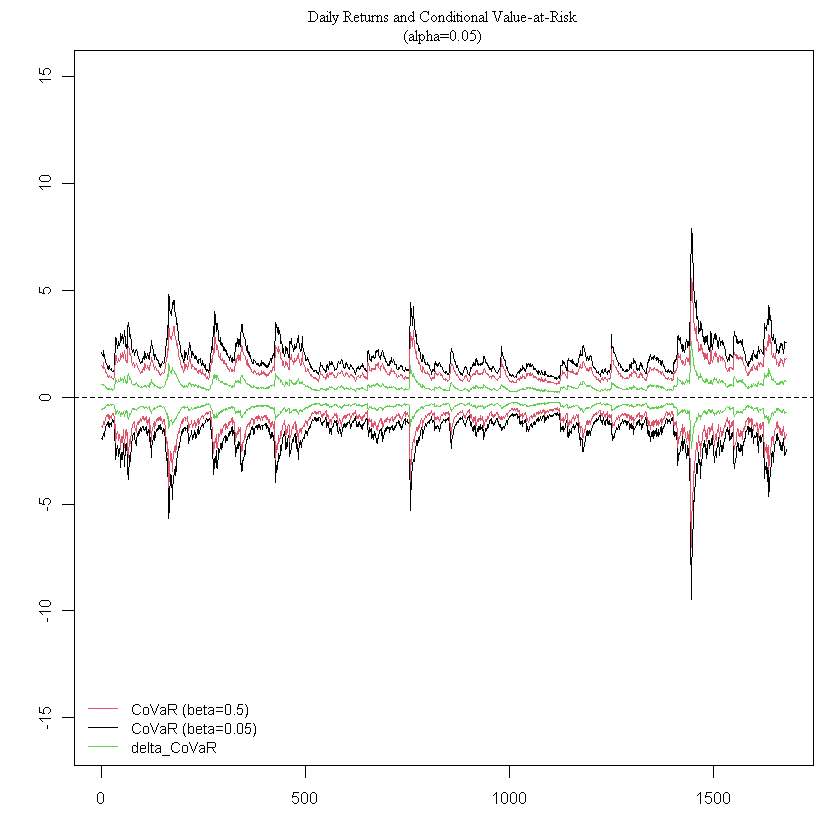

In [90]:
##plot the dynamic CoVaR and delta CoVaR
op <- par(mfrow=c(1,1), mgp=c(1.5, 0.8,0), mar= .1+c(3,3,2,1),
font.main=6, font.lab=6)
n <- length(ts_df_1$cbank)
tt <- seq(1:length(ts_df_1$cbank))
plot(tt,ts_df$cbank, type = "n", main =paste('Daily Returns and Conditional Value-at-Risk\n',
    "(alpha=", 0.05, ")", sep = ""), ylab = '', xlab = '', xlim=c(1,n),
            ylim = c(-16, 15), 
           cex.main = 0.8,  cex.lab = 0.9, cex.axis = 0.8)
        points(ts_df$cbank, pch = 19, col = 'gray', cex=0.5)
        abline(h = 0, col = "1", lty = 2)
lines(tt,CoVaR_005_005, lwd = 1, col = 1)
lines(tt,CoVaR_005_050, lwd = 1, col = 2,lty=1)
lines(tt,delta_CoVaR_005_005, lwd = 1, col = 3,lty=1)
lines(tt,CoVaR_095_005, lwd = 1, col = 1)
lines(tt,CoVaR_095_050, lwd = 1, col = 2,lty=1)
lines(tt,delta_CoVaR_095_005, lwd = 1, col = 3,lty=1)

legend("bottomleft", c("CoVaR (beta=0.5)", "CoVaR (beta=0.05)", 
            "delta_CoVaR"), col = c("2", "1", "3"), cex = 0.75, 
          lty = c(1, 1, 1), lwd = c(1, 1, 1), bty = "n")

dynamic <- cbind(CoVaR_005_050,CoVaR_005_005,delta_CoVaR_005_005,
CoVaR_095_050, CoVaR_095_005,delta_CoVaR_095_005,
ts_df$cbank)

head(dynamic)


In [91]:
write.csv(dynamic, "E:\\硕士毕业论文\\base_CoVaR\\cbank.csv")

原论文后续还进行了delta covar的KS检验来看溢出效应是否显著 可能需要补一下，如果不写上行风险的部分，就不用对比上行风险和下行风险的大小了。（再纠结一下要不要加

Re: 缺页数就加，顺便给他想一个实际意义，赢！

描述性统计感觉可以挑几个变量做一下这两个图 剩下的信息考虑放个表
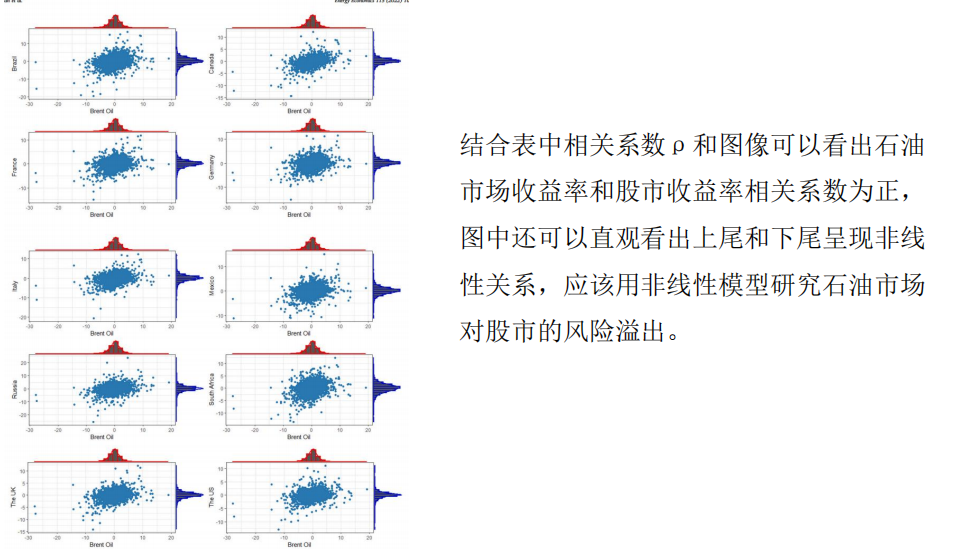
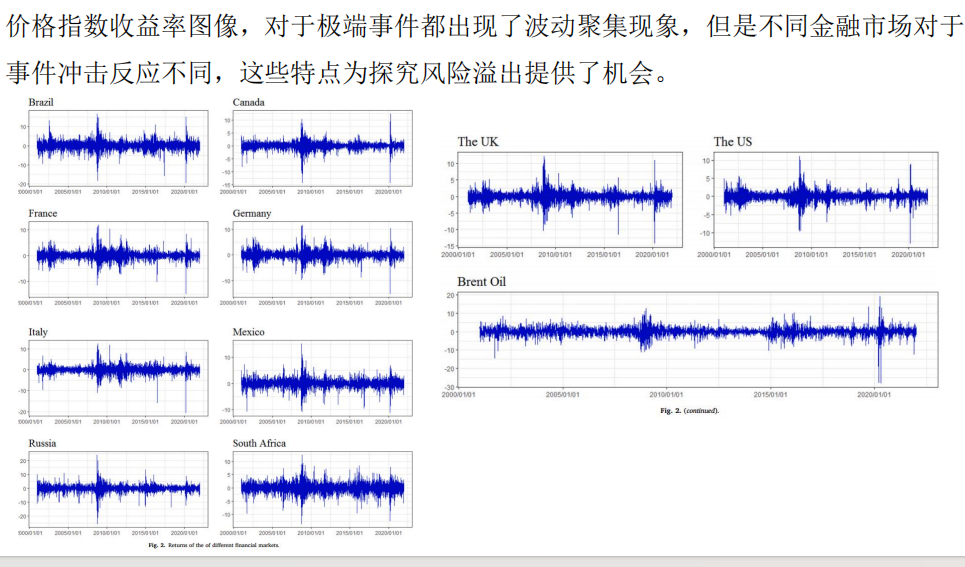